In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def calculate_score(df):
    # Create a new column that checks if answers match exactly
    df['is_correct'] = df['inferredAnswers'] == df['correctAnswers']
    
    # Calculate the overall percentage score
    total_questions = len(df)
    correct_answers = df['is_correct'].sum()
    percentage_score = (correct_answers / total_questions) * 100
    
    # Create a detailed report
    results = {
        'total_questions': total_questions,
        'correct_answers': correct_answers,
        'percentage_score': percentage_score,
        'incorrect_questions': df[~df['is_correct']][['number', 'question', 'correctAnswers', 'inferredAnswers']]
    }
    
    return results

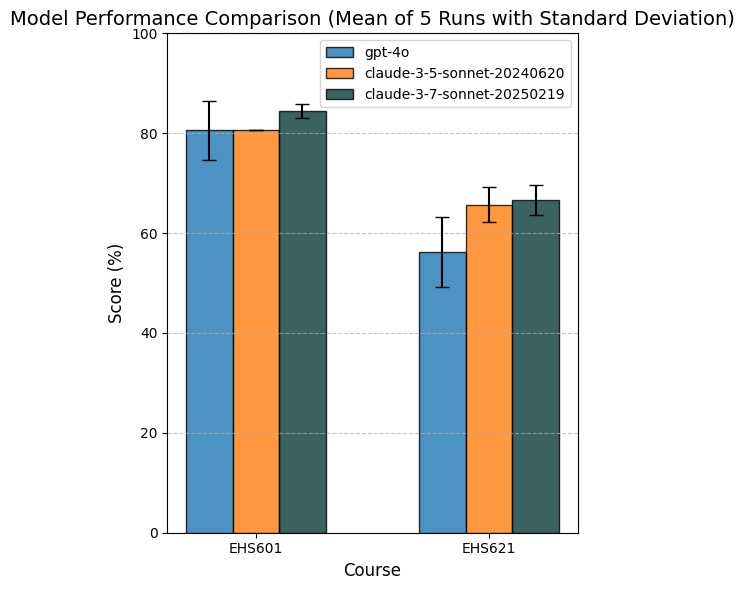

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import os

courses = ['EHS601', 'EHS621']
models = ['gpt-4o', 'claude-3-5-sonnet-20240620', 'claude-3-7-sonnet-20250219']
runs = 5  # Number of runs per model/course combination

# Create a nested dictionary to store results
results = {}

# Function to collect data from multiple runs
def collect_run_data(course, model):
    scores = []
    correct_answers = []
    total_questions = []
    
    # Look for all files matching the pattern
    for run in range(1, runs + 1):
        filename = f'{course}_{model}_{run}.csv'
        try:
            quiz_results = pd.read_csv(filename)
            score_data = calculate_score(quiz_results)
            # print(score_data)
            
            scores.append(score_data['percentage_score'])
            correct_answers.append(score_data['correct_answers'])
            total_questions.append(score_data['total_questions'])
        except Exception as e:
            print(f"Error loading {filename}: {e}")
    
    # Calculate means and standard deviations
    if scores:
        return {
            'mean_score': np.mean(scores),
            'std_score': np.std(scores),
            'mean_correct': np.mean(correct_answers),
            'std_correct': np.std(correct_answers),
            'total_questions': total_questions[0] if total_questions else 0,
            'individual_scores': scores
        }
    else:
        return {
            'mean_score': 0,
            'std_score': 0,
            'mean_correct': 0,
            'std_correct': 0,
            'total_questions': 0,
            'individual_scores': []
        }

# Calculate and store scores for each course and model
for c in courses:
    if c not in results:
        results[c] = {}
    
    for m in models:
        results[c][m] = collect_run_data(c, m)

# Set up the plot
plt.figure(figsize=(5, 6))

# Set bar width and positions
bar_width = 0.2
x = np.arange(len(courses))  # Number of courses

# Create bars for each model using different colors
colors = ['#1f77b4', '#ff7f0e', '#073b3a']
bars = []

for i, model in enumerate(models):
    # Get mean scores and standard deviations
    model_scores = [results[c][model]['mean_score'] for c in courses]
    model_errors = [results[c][model]['std_score'] for c in courses]
    
    position = x + (i - len(models)/2 + 0.5) * bar_width
    bar = plt.bar(position, model_scores, bar_width, 
                 yerr=model_errors, label=model, color=colors[i], 
                 edgecolor='k', capsize=5, alpha=0.8, error_kw={'elinewidth': 1.5})
    bars.append(bar)


# Add labels and title
plt.xlabel('Course', fontsize=12)
plt.ylabel('Score (%)', fontsize=12)
plt.title('Model Performance Comparison (Mean of 5 Runs with Standard Deviation)', fontsize=14)
plt.ylim(0, 100)

# Set x-ticks and labels
plt.xticks(x, courses)

# Add legend
plt.legend()

# Add grid for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)


plt.tight_layout()